# RDataFrame advanced features
There are many more features available with the RDataFrame that might serve your analysis needs!

## Working with `numpy` arrays
- RDataFrame offers interoperability with `numpy` arrays. 

- It can be created from a dictionary of such arrays and it can also export its contents to the same format. 

- All operations are available also when using the `numpy`-based dataset.

- **Note:** this support is limited to one-dimensional numpy arrays, which are directly mapped to columns in the RDataFrame.

In [1]:
import numpy
import ROOT

np_dict = {colname: numpy.random.rand(100) for colname in ["a","b","c"]}

df = ROOT.RDF.FromNumpy(np_dict)

print(f"Columns in the RDataFrame: {df.GetColumnNames()}")

Welcome to JupyROOT 6.30/04
Columns in the RDataFrame: { "a", "b", "c" }


Number of rows in the dataset: 100
Average value of column a: 0.4506918230422041


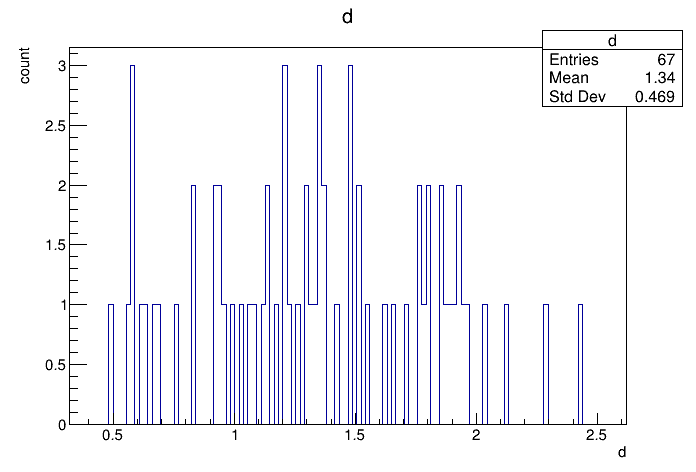

In [2]:
co = df.Count()
m_a = df.Mean("a")

fil1 = df.Filter("c < 0.7")
def1 = fil1.Define("d", "a+b+c")
h = def1.Histo1D("d")

c = ROOT.TCanvas()
h.Draw()

print(f"Number of rows in the dataset: {co.GetValue()}")
print(f"Average value of column a: {m_a.GetValue()}")
c.Draw()

In [3]:
# Export the modified dataframe to a dictionary of numpy arrays

np_dict_mod = def1.AsNumpy()

np_dict_mod

{'a': ndarray([1.88327405e-01, 2.59742399e-01, 5.30700323e-01, 3.01918946e-01,
          3.05100492e-01, 3.73404658e-01, 4.96420755e-01, 7.06724759e-01,
          4.34328157e-01, 9.97772735e-01, 2.51756900e-01, 6.94545566e-01,
          7.14615970e-01, 2.42057523e-01, 1.43155672e-01, 9.69231617e-01,
          9.98764525e-02, 5.72325072e-01, 6.20568264e-01, 2.43710020e-01,
          9.18056689e-01, 1.83731423e-01, 3.21719242e-01, 4.58297837e-01,
          7.93604202e-01, 2.45393638e-01, 7.30943967e-01, 7.09561510e-01,
          1.34357986e-04, 1.62207250e-01, 5.08888336e-01, 5.88898918e-01,
          7.38322404e-01, 1.88050970e-01, 4.21257580e-01, 2.41999235e-01,
          7.64763644e-02, 7.62571906e-01, 5.98050891e-02, 5.05586086e-02,
          2.19784131e-01, 7.59917287e-01, 1.68816884e-01, 7.31929472e-01,
          4.85445238e-01, 7.73879477e-01, 4.01368731e-01, 9.08133578e-01,
          9.81587246e-01, 6.78216290e-01, 9.19885070e-01, 3.02594458e-01,
          5.08751073e-01, 1.51376

## Multiple concurrent RDataFrame runs
If your analysis needs multiple RDataFrames to run (for example multiple dataset samples, data vs simulation etc.), make use of `ROOT.RDF.RunGraphs` 

In [4]:
ROOT.EnableImplicitMT()
treename1 = "myDataset"
filename1 = "../../data/collections_dataset.root"
treename2 = "dataset"
filename2 = "../../data/example_file.root"

df1 = ROOT.RDataFrame(treename1, filename1)
df2 = ROOT.RDataFrame(treename2, filename2)
h1 = df1.Histo1D("px")
h2 = df2.Histo1D("a")


ROOT.RDF.RunGraphs((h1, h2))
ROOT.DisableImplicitMT()

Warning in <RTaskArenaWrapper>: CPU Bandwith Control Active. Proceeding with 4 threads accordingly


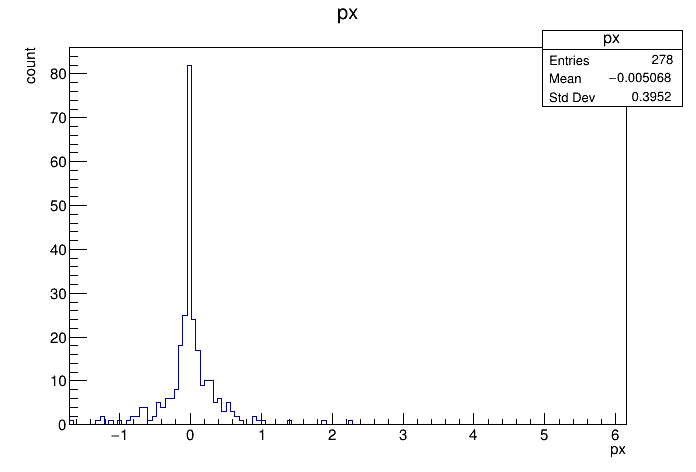

In [5]:
c = ROOT.TCanvas()
h1.Draw()
c.Draw()

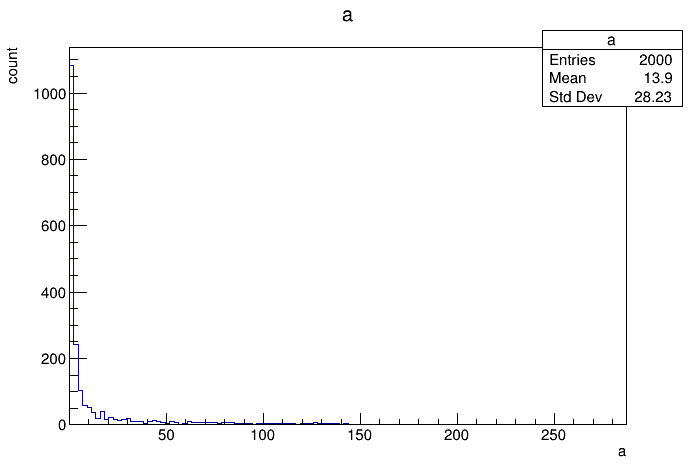

In [6]:
c = ROOT.TCanvas()
h2.Draw()
c.Draw()

# Re-defining values of a column

Sometimes you might want to keep a column with the same name, but modify its values. This is available via the `Redefine` method.

In [7]:
df = ROOT.RDataFrame(5).Define("x", "42")
df.Display().Print()

+-----+----+
| Row | x  | 
+-----+----+
| 0   | 42 | 
+-----+----+
| 1   | 42 | 
+-----+----+
| 2   | 42 | 
+-----+----+
| 3   | 42 | 
+-----+----+
| 4   | 42 | 
+-----+----+


In [8]:
df = df.Redefine("x", "x * 10")
df.Display().Print()

+-----+-----+
| Row | x   | 
+-----+-----+
| 0   | 420 | 
+-----+-----+
| 1   | 420 | 
+-----+-----+
| 2   | 420 | 
+-----+-----+
| 3   | 420 | 
+-----+-----+
| 4   | 420 | 
+-----+-----+


Notice how we could use the previous values of the `"x"` column to define the new values.

# Distributed RDataFrame

An `RDataFrame` analysis written in Python can be executed both *locally* - possibly in parallel on the cores of the machine - and *distributedly* by offloading computations to external resources, which include:

- [Spark](https://spark.apache.org/) and 
- [Dask](https://dask.org/) clusters. 

- This feature is enabled by the architecture depicted below.

- It shows that RDataFrame computation graphs can be mapped to different kinds of resources via backends.

- In this notebook we will exercise the Dask backend, which divides an `RDataFrame` input dataset in logical ranges and submits computations for each of those ranges to Dask resources.

<img src="../../images/DistRDF_architecture.png" alt="Distributed RDataFrame">

## Create a Dask client

- In order to work with a Dask cluster we need a `Client` object.
- It represents the connection to that cluster and allows to configure execution-related parameters (e.g. number of cores, memory). 
- The client object is just the intermediary between our client session and the cluster resources, 
- Dask supports many different resource managers.
- We will follow the [Dask documentation](https://distributed.dask.org/en/stable/client.html) regarding the creation of a `Client`.

In [9]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=2, threads_per_worker=1, processes=True, memory_limit="2GiB")
client = Client(cluster)

## Create a ROOT dataframe

We now create an RDataFrame based on the same dataset seen in the exercise [rdataframe-dimuon](exercises/rdataframe-dimuon.ipynb).

A Dask `RDataFrame` receives two extra parameters: 
- the number of partitions to apply to the dataset (`npartitions`)
- the `Client` object (`daskclient`). 

Besides this detail, a Dask `RDataFrame` is not different from a local `RDataFrame`: the analysis presented in this notebook would not change if we wanted to execute it locally.

In [10]:
# Use a Dask RDataFrame
RDataFrame = ROOT.RDF.Experimental.Distributed.Dask.RDataFrame

df = RDataFrame("h42",
                "https://root.cern/files/h1big.root",
                npartitions=4,
                daskclient=client)

## Run your analysis unchanged

- From now on, the rest of your application can be written **exactly** as we have seen with local RDataFrame. 

- The goal of the distributed RDataFrame module is to support all the traditional RDataFrame operations (those that make sense in a distributed context at least). 

- Currently only a subset of those is available and can be found in the corresponding [section of the documentation](https://root.cern/doc/master/classROOT_1_1RDataFrame.html#distrdf)

In [11]:
%%time
df1 = df.Filter("nevent > 1")
df2 = df1.Define("mpt","sqrt(xpt*xpt + ypt*ypt)")
c = df.Count()
m = df2.Mean("mpt")
print(f"Number of events after processing: {c.GetValue()}")
print(f"Mean of column 'mpt': {m.GetValue()}")

Number of events after processing: 283813
Mean of column 'mpt': 0.13190819625023323
CPU times: user 659 ms, sys: 217 ms, total: 876 ms
Wall time: 10.9 s
